# Multiclass logistic regression from scratch

If you've made it through our tutorial on linear regression from scratch, then you're past the hardest part. You already know how to load and manipulate data, build computation graphs on the fly, and take derivatives. You also know how to define a loss function, construct a model, and write your own optimizer. 

Nearly all neural networks that we'll build in the real world consist of these same fundamental parts. The main differences will be the type and scale of the data, and the complexity of the models. And every year or two, a new hipster optimizer comes around, but at their core they're all subtle variations of stochastic gradient descent.

So let's work on a more interesting problem now. We're going to classify images of handwritten digits like these:
![png](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/example/mnist.png) 
We're going to implement a model called multiclass logistic regression. Other common names for this model include softmax regression and multinomial regression. To start, let's import our bag of libraries.

# 多类逻辑回归从0开始

如果你已经读过我们的教程线性回归从零开始，那么你已经过去最困难的部分。您已经知道如何加载和操作数据，快速构建计算图，并派生出派生词。您还知道如何定义损失函数、构造模型和编写自己的优化器。

几乎所有我们在现实世界中构建的神经网络都是由这些相同的基本部分组成的。主要的区别是数据的类型和规模，以及模型的复杂性。每一年或两年，一个新的时髦的优化器来到我们周围，但他们的核心是随机梯度下降所有微妙的变化。

In [1]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
import numpy as np

We'll also want to set the compute context for our modeling. Feel free to go ahead and change this to mx.gpu(0) if you're running on an appropriately endowed machine.

我们还希望为我们的建模设置计算上下文。如果您运行在一台适当的机器上，请随意更改为 mx.gpu(0)。

In [2]:
ctx = mx.cpu()

## The MNIST dataset

This time we're going to work with real data, each a 28 by 28 centrally cropped black & white photograph of a handwritten digit. Our task will be come up with a model that can associate each image with the digit (0-9) that it depicts.

To start, we'll use MXNet's utility for grabbing a copy of this dataset. The datasets accept a transform callback that can preprocess each item. Here we cast data and label to floats and normalize data to range [0, 1]:

## MNIST 数据集
这一次我们将使用真实的数据，每一个28到28个中央剪裁的黑白数字的手写数字。我们的任务是拿出一个可以把每个图像与数字（0-9）关联在一起的模型。
开始，我们将使用MXNet工具抓取一个数据集的副本。数据集接受一个可以对每个项目进行预处理的转换回调函数。在这里，我们将数据和标签转换成浮点数，并将数据正常化到范围[0, 1]：

In [3]:
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
mnist_train = mx.gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test = mx.gluon.data.vision.MNIST(train=False, transform=transform)

There are two parts of the dataset for training and testing. Each part has N items and each item is a tuple of an image and a label:

数据集有用于训练和测试的两个部分。每个部分有n个项，每个项是一个图像和一个标签的元组。

In [7]:
image, label = mnist_train[0]
print(image.shape, label)


(28, 28, 1) 5.0


Note that each image has been formatted as a 3-tuple (height, width, channel). For color images, the channel would have 3 dimensions (red, green and blue).

请注意，每个图像被格式化为一个三元组（高度、宽度、通道）。对于彩色图像，通道将有3个维度（红色、绿色和蓝色）。

## Record the data and label shapes

Generally, we don't want our model code to care too much about the exact shape of our input data. This way we could switch in a different dataset without changing the code that follows. Let's define variables to hold the number of inputs and outputs.


## 记录数据和标签形状

一般来说，我们不希望我们的模型代码过分关注输入数据的精确形状。通过这种方式，我们可以切换到不同的数据集，而不必更改下面的代码。让我们定义变量来保存输入和输出的数量。



In [8]:
num_inputs = 784
num_outputs = 10

Machine learning libraries generally expect to find images in (batch, channel, height, width) format. However, most libraries for visualization prefer (height, width, channel). Let's transpose our image into the expected shape. In this case, matplotlib expects either (height, width) or (height, width, channel) with RGB channels, so let's broadcast our single channel to 3.


机器学习库通常希望在（批处理、通道、高度、宽度）格式中找到图像。然而，大多数可视化的库都喜欢（高度、宽度、通道）。让我们把图像转换成期望的形状。在这种情况下，matplotlib要求（高度、宽度）或 带有RGB通道的（高度、宽度、通道），所以让我们广播单个渠道到3个渠道。

In [9]:
im = mx.nd.tile(image, (1,1,3))
print(im.shape)

(28, 28, 3)


Now we can visualize our image and make sure that our data and labels line up.

现在我们可以可视化我们的图像，确保我们的数据和标签排成一排。

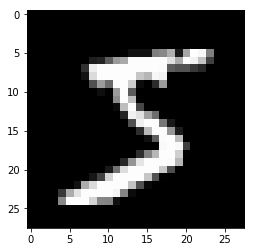

In [10]:
import matplotlib.pyplot as plt
plt.imshow(im.asnumpy())
plt.show()

Ok, that's a beautiful five. 

## Load the data iterator

Now let's load these images into a data iterator so we don't have to do the heavy lifting. 

## 加载数据迭代器

现在，让我们把这些图像加载到数据迭代器中，这样我们就不必做繁重的工作了。

In [12]:
batch_size = 64
train_data = mx.gluon.data.DataLoader(mnist_train, batch_size, shuffle=True)

We're also going to want to load up an iterator with *test* data. After we train on the training dataset we're going to want to test our model on the test data. Otherwise, for all we know, our model could be doing something stupid (or treacherous?) like memorizing the training examples and regurgitating the labels on command.

我们还想加载一个带有*test* 数据的迭代器。在训练数据集上训练之后，我们将要在测试数据上测试我们的模型。否则，我们所知道的，我们的模型可能是在做一些愚蠢的事情（或不可信的）？像记忆训练实例和照搬的标签命令。


In [13]:
test_data = mx.gluon.data.DataLoader(mnist_test, batch_size, shuffle=False)

## Allocate model parameters

Now we're going to define our model. For this example, we're going to ignore the multimodal structure of our data and just flatten each image into a single 1D vector with 28x28 = 784 components. 

Because our task is multiclass classification, we want to assign a probability to each of the classes P(Y=c|X) given the input X. In order to do this we're going to need one vector of 784 weights for each class, connecting each feature to the corresponding output. Because there are 10 classes, we can collect these weights together in a 784 by 10 matrix.

We'll also want to allocate one offset for each of the outputs. We call these offsets the *bias term* and collect them in the 10-dimensional array ``b``.

## 分配模型参数

现在我们来定义我们的模型。在这个例子中，我们会忽略我们多样的数据结构和展开每个图像到一个28x28 = 784成分单一的一维向量。

因为我们的任务是多类分类，我们要分配一个概率给每个给定输入X类P（Y = C | x）。对于每个类，我们需要784个权重向量，将每个特征连接到相应的输出。因为有10个类，我们可以用784到10的矩阵来收集这些权重。

我们还希望为每个输出分配一个偏移量。我们将这些偏移称为*偏置项*，并将它收集到10维数组中。




In [14]:
W = nd.random_normal(shape=(num_inputs, num_outputs),ctx=ctx)
b = nd.random_normal(shape=num_outputs,ctx=ctx)

params = [W, b]

As before, we need to let MXNet know that we'll be expecting gradients corresponding to each of these parameters during training.

之前，在训练期间，我们需要让MXNet知道我们会期望梯度对应于这些参数

In [15]:
for param in params:
    param.attach_grad()

## Multiclass logistic regression

In the linear regression tutorial, we performed regression, so we had just one output *yhat* and tried to push this value as close as possible to the true target *y*. Here, instead of regression, we are performing *classification*, where we want to assign each input *X* to one of *L* classes. 

The basic modeling idea is that we're going to linearly map our input *X* onto 10 different real valued outputs ``y_linear``. Then before, outputting these values, we'll want to normalize them so that they are non-negative and sum to 1. This normalization allows us to interpret the output yhat as a valid probability distribution.

## 多类逻辑回归

在线性回归的教程，我们进行了回归，所以我们只有一个输出*yhat*，试图让这个值尽量接近真实的目标*y*，在这里，不是回归，我们进行分类，我们要给每一个输入*X* 一个*L* 类。

基本的建模思想是，我们将线性映射输入*X*到10个不同的实际输出值 ``y_linear``。然后，输出这些值，我们希望正则化它们，使它们为非负数，相加的和为1。正规化允许我们通过一个有效的概率分布来解释输出。


In [16]:
def softmax(y_linear):
    exp = nd.exp(y_linear-nd.max(y_linear))
    norms = nd.sum(exp, axis=0, exclude=True).reshape((-1,1))
    return exp / norms

In [19]:
sample_y_linear = nd.random_normal(shape=(2,10))
print(sample_y_linear)
sample_yhat = softmax(sample_y_linear)
print(sample_yhat)


[[ 0.47811311  0.96285349  1.72885859  0.42453527  1.72286677 -0.32012343
  -0.9782294   2.06755948 -1.71680093  0.47031024]
 [ 0.24345131  0.30026805  1.90792441  0.06960804 -0.29493463  1.2498771
  -1.96911538 -1.7219516  -0.68004459 -0.33261022]]
<NDArray 2x10 @cpu(0)>

[[ 0.05805701  0.09427025  0.20278998  0.0550283   0.20157854  0.02613274
   0.01353235  0.2845394   0.0064657   0.05760575]
 [ 0.07867803  0.08327769  0.41564727  0.06612326  0.04592355  0.21524774
   0.0086089   0.01102274  0.03124527  0.04422554]]
<NDArray 2x10 @cpu(0)>


Let's confirm that indeed all of our rows sum to 1. 

让我们确认所有的行总和确实为1。

In [18]:
print(nd.sum(sample_yhat, axis=1))


[ 1.  1.]
<NDArray 2 @cpu(0)>


But for small rounding errors, the function works as expected.

## Define the model

Now we're ready to define our model

In [20]:
def net(X):
    y_linear = nd.dot(X, W) + b
    yhat = softmax(y_linear)
    return yhat

## The  cross-entropy loss function

Before we can start training, we're going to need to define a loss function that makes sense when our prediction is a  probability distribution. 

The relevant loss function here is called cross-entropy and it may be the most common loss function you'll find in all of deep learning. That's because at the moment, classification problems tend to be far more abundant than regression problems. 

The basic idea is that we're going to take a target Y that has been formatted as a one-hot vector, meaning one value corresponding to the correct label is set to 1 and the others are set to 0, e.g. ``[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]``. 


The basic idea of cross-entropy loss is that we only care about how much probability the prediction assigned to the correct label. In other words, for true label 2, we only care about the component of yhat corresponding to 2. Cross-entropy attempts to maximize the log-likelihood given to the correct labels.


## 交叉熵损失函数

在我们开始训练之前，我们需要定义一个损失函数。 在我们的预测是一个概率分布的时候，
这里的相关损失函数称为交叉熵，它可能是所有深度学习中最常见的损失函数。这是因为目前分类问题往往比回归问题丰富得多。

基本思想是将目标格式化为一个热向量，意思是对应于正确标签的一个值设置为1，其他值设置为0，例如[ 0, 1, 0，0, 0, 0，0, 0, 0，0 ]。
交叉熵损失的基本思想是，我们只关心分配给正确标签的预测概率。换句话说，对于真正的标签2，我们只关心2相应的组件。交叉熵试图最大限度地提高正确标签的对数似然。

In [21]:
def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat), axis=0, exclude=True)

## Optimizer

For this example we'll be using the same stochastic gradient descent (SGD) optimizer as last time.

In [22]:
def SGD(params, lr):    
    for param in params:
        param[:] = param - lr * param.grad

## Write evaluation loop to calculate accuracy

While cross-entropy is nice, differentiable loss function, it's not the way humans usually evaluate performance on multiple choice tasks. More commonly we look at accuracy, the number of correct answers divided by the total number of questions. Let's write an evaluation loop that will take a data iterator and a network, returning the model's accuracy  averaged over the entire dataset.

## 写求值循环计算准确度

虽然交叉熵是好的，可微的损失函数，但这并不是人类通常在多项选择任务上评估性能的方法。更常见的是我们看准确度，正确答案的数量除以问题总数。让我们编写一个包含数据迭代器和网络的求值循环，返回模型在整个数据集上的平均值。


In [23]:
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

Because we initialized our model randomly, and because roughly one tenth of all examples belong to each of the ten classes, we should have an accuracy in the ball park of .10.

因为我们随机初始化了我们的模型，因为大约十分之一的例子都属于这十个类中的每一个，所以我们应该在10。

In [24]:
evaluate_accuracy(test_data, net)

0.16329999

## Execute training loop

In [25]:
epochs = 10
moving_loss = 0.
learning_rate = .001
smoothing_constant = .01
niter=0

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * nd.mean(loss).asscalar()
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)
            
    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, est_loss, train_accuracy, test_accuracy))       

Epoch 0. Loss: 1.34971372768, Train_acc 0.754017, Test_acc 0.7633
Epoch 1. Loss: 0.899625499827, Train_acc 0.813233, Test_acc 0.8251
Epoch 2. Loss: 0.811315553979, Train_acc 0.836983, Test_acc 0.8499
Epoch 3. Loss: 0.723591087432, Train_acc 0.850333, Test_acc 0.8618
Epoch 4. Loss: 0.642600380623, Train_acc 0.859183, Test_acc 0.8684
Epoch 5. Loss: 0.609362499913, Train_acc 0.866733, Test_acc 0.8745
Epoch 6. Loss: 0.585710662143, Train_acc 0.871617, Test_acc 0.8778
Epoch 7. Loss: 0.545416593207, Train_acc 0.875167, Test_acc 0.8817
Epoch 8. Loss: 0.508563420335, Train_acc 0.878633, Test_acc 0.8848
Epoch 9. Loss: 0.492235264934, Train_acc 0.881983, Test_acc 0.8874


## Using the model for prediction
Let's make it more intuitive by picking 10 random data points from the test set and use the trained model for predictions.

(10, 28, 28, 1)


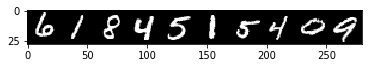

model predictions are: 
[ 6.  1.  8.  4.  5.  1.  8.  4.  0.  9.]
<NDArray 10 @cpu(0)>


In [26]:
# Define the function to do prediction
def model_predict(net,data):
    output = net(data)
    return nd.argmax(output, axis=1)

# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mnist_test, 10, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(ctx)
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))
    
    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break

## Conclusion

Jeepers. We can get nearly 90% accuracy at this task just by training a linear model for a few seconds! You might reasonably conclude that this problem is too easy to be taken seriously by experts.

But until recently, many papers (Google Scholar says 13,800) were published using results obtained on this data. Even this year, I reviewed a paper whose primary achievement was an (imagined) improvement in performance. While MNIST can be a nice toy dataset for testing new ideas, we don't recommend writing papers with it. 


结论
天啊。我们只需训练一个线性模型几秒钟就能得到接近90%的精确度！你可以合理地得出这样的结论：这个问题很容易被专家们认真对待。
但直到最近，许多论文（谷歌学者说13800）都是根据这个数据获得的结果发表的。甚至在今年，我还回顾了一篇论文，其主要成就是（想象中）业绩的提高。在MNIST可以测试新的想法，一个好玩具的数据集，我们不推荐用它写论文。

## Next
[Softmax regression with gluon](../chapter02_supervised-learning/softmax-regression-gluon.ipynb)

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)